In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
file1 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/drag_010/state_007.nc')
file2 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/drag_010/kpp_state_007.nc')

t0 = 60 # Start from day 30
tn = len(file1.T) # End day
state1 = file1.isel(Y = range(1,10), T = range(t0,tn)) # Remove the boundary walls in y direction
state2 = file2.isel(Y = range(1,10), T = range(t0-1,tn-1)) # Remove the boundary walls in y direction

In [3]:
Hs = 10
Qf = 700

X = state1.X.data
x_dist = X / 1000
depth = state1.Z.data
Az = state2.KPPviscAz.data.mean(axis=(0,2)) # Time-average and Y-average vertical eddy viscosity
pt = state1.Temp.data.mean(axis=(0,2))
u0 = state1.U.data # dims = T, Z, Y, Xp1
u_ymean = (u0[:, :, :, 1:].mean(2) + u0[:, :, :, :-1].mean(2)) / 2
u = u_ymean.mean(0) # dims = Z, X
u[u==0] = np.nan
#u_x = np.gradient(u, X, axis=1)
#u_z = np.gradient(u, depth, axis=0)
#vis = np.gradient(Az*u_z, depth, axis=0)
u_x = np.diff(u, axis=1, prepend=0) / 200
u_z = np.diff(pt, axis=0, prepend=0)
dz = np.tile(np.diff(-depth,prepend=0),(50,1)).T

#vis = np.diff(Az*(u_z/dz), axis=0, prepend=0) / dz
vis = Az * u_z
adv = u * u_x
R = abs(vis/adv)

R[R>5] = 5

/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


In [4]:
# Find the uppler and lower layer depth above the sill crest
def Layer(u):
    # Layer interface, zero velocity crossing point
    #l = np.empty(len(X)-1)
    h1 = np.empty(len(X)-2)
    for i in range(1,len(X)-1):
        l = np.where(u[:, i] < 0)[-1][0] - 1
        #h1[i-1] = -depth[l]
        # Calculate layer depth
        if l <= 9:
            h1[i-1] = -depth[l]+0.25
        elif l <= 19:
            h1[i-1] = -depth[l]+0.5
        elif l <= 29:
            h1[i-1] = -depth[l]+0.75
        elif l <= 39:
            h1[i-1] = -depth[l]+2
        elif l <= 49:
            h1[i-1] = -depth[l]+4
    return h1

In [5]:
h1 = Layer(u)

Text(0, 0.5, 'Depth (m)')

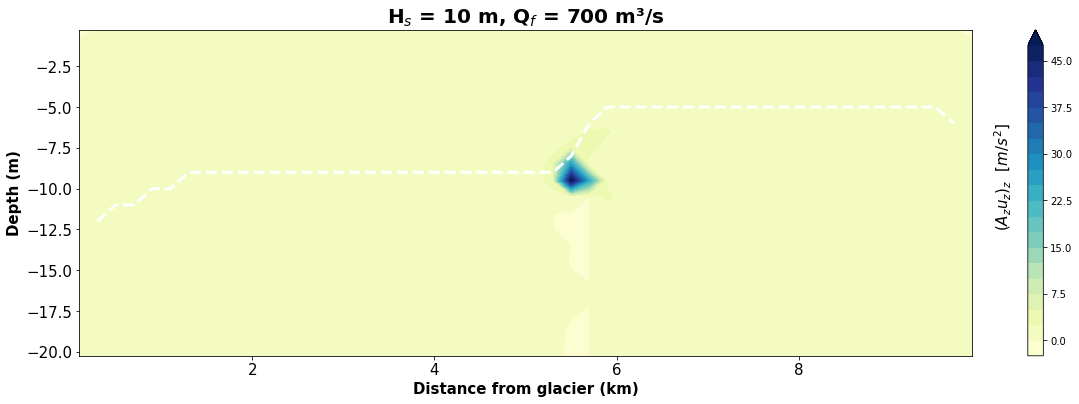

In [6]:
fig_path = "/Users/weiyangbao/Documents/Model_outputs/Vis_Adv/"
#fig_path = "/home/1959/Jupyter_Figs/sill30/FrPseries/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig, ax = plt.subplots(figsize=(20,6)) 
#ca = np.linspace(1e-7,1e-6,10) # Contour range for viscous term
#ca = np.linspace(0,5,11) # Contour range for R
#plt.contourf(x_dist,depth[:24], vis[:24,:], 10, cmap='YlGnBu', extend='both')

ca = np.linspace(-18,0,10) # Contour range for viscous term
plt.contourf(x_dist,depth[:24], vis[:24,:]*40000, 20, cmap='YlGnBu', extend='max')

#CS = plt.contour(x_dist,depth[:24],vis[:24,:],10, colors = 'gray')
#plt.clabel(CS, fmt='%1.10f', fontsize=15, inline=1)

plt.plot(x_dist[1:-1],-h1,'--w', lw=3)
#ax.axvline(x_dist[28],color='g', lw=3)

import matplotlib.ticker
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

#cbar.ax.tick_params(labelsize=12)
cbar = plt.colorbar()
#cbar = plt.colorbar(ticks=np.linspace(1e-7,1e-6,10), format=OOMFormatter(-7, mathText=True))
#cbar.set_label(r'$\frac{(A_zu_z)_z}{uu_x}$', size=15, weight='bold', rotation=0)
cbar.set_label(r'$(A_zu_z)_z$  $[m/s^2]$', size=15, weight='bold', labelpad=-80, y=0.55)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.title('H$_{s}$ = '  + str(Hs) + ' m, Q$_{f}$ = ' + str(Qf) + ' m\u00B3/s', size = 20, weight = 'bold')
ax.set_xlabel('Distance from glacier (km)', size = 15, weight = 'bold')
ax.set_ylabel('Depth (m)', size = 15, weight = 'bold')

#fig.savefig(fig_path + '/Vis' + str(Hs) + '.png', dpi = 150, bbox_inches='tight')

(array([135.,  27.,  17.,  17.,  17.,  13.,   9.,   3.,   2.,   2.]),
 array([0.e+00, 1.e-08, 2.e-08, 3.e-08, 4.e-08, 5.e-08, 6.e-08, 7.e-08,
        8.e-08, 9.e-08, 1.e-07]),
 <a list of 10 Patch objects>)

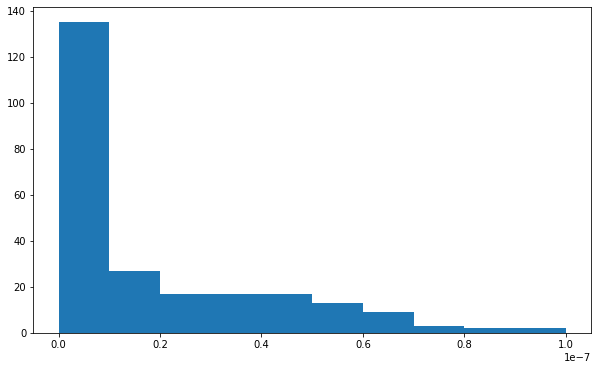

In [7]:
fig = plt.subplots(figsize=(10,6)) 
A = vis[:24,:]
plt.hist(A[~np.isnan(A)], range=(0,1e-7))

In [10]:
V = vis * 200 * 200
V[:,27]

array([ 0.00000000e+00,  5.57310616e-03,  1.05226973e-02,  1.20064303e-02,
        1.24336782e-02,  1.28416619e-02,  1.54942174e-02,  1.40679016e-02,
        1.77033457e-02,  1.40976564e-02,  3.90689638e-02,  6.08036773e-02,
        4.57519141e+00,  2.59672065e+01,  4.90401464e+01,  1.22425390e+00,
       -1.34729348e-01, -2.55351458e-02, -1.57137450e-04, -2.99031033e-03,
        5.63838775e-03,  2.72948057e-03, -3.58104487e-03, -4.45546235e-03,
       -2.66422107e-03, -6.65192434e-04,  3.81964771e-03,  4.39454521e-03,
        7.22903508e-03,  3.18693871e-03,  7.19477221e-03, -2.08306159e-04,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])